In [9]:
my_seed = 2024
import numpy as np

np.random.seed(my_seed)
import random as rn
rn.seed(my_seed)
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
import tensorflow as tf
tf.set_random_seed(my_seed)

log_device_placement = False
import sys
if "log_device_tf" in sys.argv: 
    log_device_placement = True

session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0, device_count = {"GPU" : 0},
                              log_device_placement=log_device_placement)
import keras
from keras import backend as K

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

from keras.optimizers import Adam, SGD, Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
from bioinformatics_helpers.utils import get_mendelian_dataset
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from keras import Sequential
from keras.layers import Dense, Activation, LeakyReLU
from bioinformatics_helpers.utils import hingesig_tf
from bioinformatics_helpers.utils import ExhaustiveSearch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


In [4]:
feature_per_example = 26
batch_size = 5000

In [5]:

def create_model(architecture=(2,)):
    model = Sequential()
    weights_initializer = keras.initializers.glorot_normal(seed=my_seed)
    bias_init = keras.initializers.RandomNormal(mean=0.1, stddev=0.05, seed=my_seed)
    input_dim = feature_per_example
    for units in architecture:
        model.add(
            Dense(
                units,
                input_dim = input_dim,
                kernel_initializer = weights_initializer,
                bias_initializer = bias_init,
                activation="relu"
            )
        )
    model.add(
        Dense(
            1,
            kernel_initializer=weights_initializer,
            bias_initializer=keras.initializers.zeros(),
            activation='sigmoid'
    ))
    optimizer = SGD()
    model.compile(loss=hingesig_tf, optimizer=optimizer)
    return model

In [6]:
train_X, train_y, test_X, test_y = get_mendelian_dataset()


In [7]:
def prc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
    return auc(x=recall, y=precision)

scoring = {
    'AVG_PREC': make_scorer(average_precision_score, needs_threshold=True),
    'AU_PRC' : make_scorer(prc_score, needs_threshold=True),
    'AU_ROC' : make_scorer(roc_auc_score, needs_threshold=True)
}

In [6]:
model = KerasClassifier(build_fn=create_model, verbose=1, shuffle=True, batch_size=batch_size, epochs=150, architecture=(2,))
pipe = Pipeline([("model",model)])
cv = StratifiedKFold(n_splits=5, random_state=my_seed, shuffle=True)
pipe.fit(train_X, train_y)


Epoch 1/150
981388/981388 [==============================] - 7s 7us/step - loss: 0.0264
Epoch 2/150
981388/981388 [==============================] - 6s 6us/step - loss: 0.0238
Epoch 3/150
981388/981388 [==============================] - 6s 6us/step - loss: 0.0235
Epoch 4/150
981388/981388 [==============================] - 5s 5us/step - loss: 0.0234
Epoch 5/150
981388/981388 [==============================] - 5s 6us/step - loss: 0.0233
Epoch 6/150
981388/981388 [==============================] - 4s 5us/step - loss: 0.0232
Epoch 7/150
981388/981388 [==============================] - 6s 6us/step - loss: 0.0230
Epoch 8/150
981388/981388 [==============================] - 4s 5us/step - loss: 0.0228
Epoch 9/150
981388/981388 [==============================] - 4s 4us/step - loss: 0.0225
Epoch 10/150
981388/981388 [==============================] - 4s 5us/step - loss: 0.0210
Epoch 11/150
981388/981388 [==============================] - 4s 4us/step - loss: 0.0207
Epoch 12/150
981388/981388 [==

Pipeline(memory=None,
     steps=[('model', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5f91f837b8>)])

In [7]:
test_probas = pipe.predict_proba(test_X)
train_probas = pipe.predict_proba(train_X)

981388/981388 [==============================] - 1s 1us/step


0.013659221570891769
0.002160375105747725


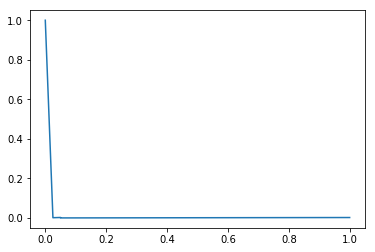

In [16]:
p,r,t = precision_recall_curve(test_y, test_probas[:,1])
print(auc(r,p))
print(average_precision_score(test_y, test_probas[:,1]))
plt.plot(r,p)
plt.show()

0.19333422726539326
0.002160375105747725


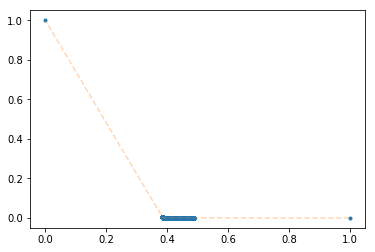

In [24]:
p,r,t = precision_recall_curve(train_y, train_probas[:,1])
print(auc(r,p))
print(average_precision_score(test_y, test_probas[:,1]))
plt.plot(r,p,".")
plt.plot(r,p,"--", alpha=0.3)
plt.show()

In [26]:
pd.Series(train_probas[:,1]).to_csv("unusual_train_probas.csv", index=False)

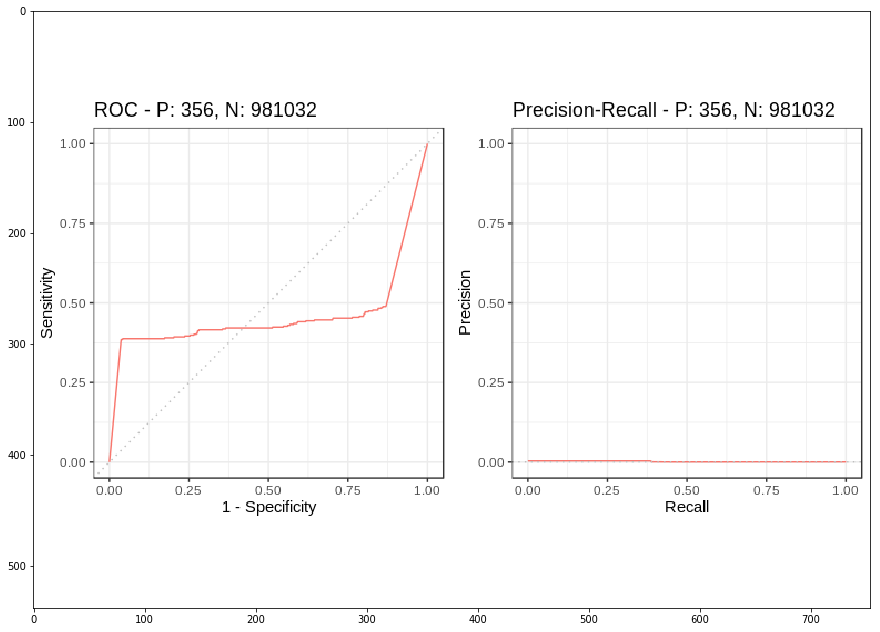

In [19]:
img = plt.imread("r_auprc_plot.png")

fig, ax = plt.subplots(figsize=(15,15))

ax.imshow(img)
